In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/food11-image-dataset/validation/Fried food/208.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/45.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/56.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/89.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/20.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/275.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/212.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/239.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/58.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/150.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/6.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/109.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/149.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/187.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/76.jpg
/kaggle/input/food11-image-datase

In [52]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
import requests
import pandas as pd
print(tf.__version__)



2.15.0


In [53]:
#create a list with the filepaths for training and testing
train_dir=Path('/kaggle/input/food11-image-dataset/training')
train_filepaths= list(train_dir.glob(r'**/*.jpg'))


In [54]:
#create a list with the filepaths for training and testing
test_dir=Path('/kaggle/input/food11-image-dataset/evaluation')
test_filepaths= list(test_dir.glob(r'**/*.jpg'))


In [55]:
#create a list with the filepaths for training and testing
val_dir=Path('/kaggle/input/food11-image-dataset/training')
val_filepaths= list(test_dir.glob(r'**/*.jpg'))


In [59]:
import pandas as pd

def image_processing(filepaths):
    # Create a dataframe with filepaths and labels from the pictures
    labels = [str(filepaths[i]).split("/")[-2] for i in range(len(filepaths))]
    
    # Convert filepaths list to a pandas Series
    filepath_series = pd.Series(filepaths, name='Filepath').astype(str)
    
    # Convert labels list to a pandas Series
    labels_series = pd.Series(labels, name='Label')
    
    # Concatenate filepaths and labels into a DataFrame
    df = pd.concat([filepath_series, labels_series], axis=1)
    
    # Shuffle the DataFrame and reset the index
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df


In [60]:
train_df=image_processing(train_filepaths)
test_df=image_processing(test_filepaths)
val_df=image_processing(val_filepaths)
print('Training set \n')
print(f'Number of pictures:{train_df.shape[0]}\n')
print(f'Number of different labels:{len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')                                   

Training set 

Number of pictures:3347

Number of different labels:11

Labels: ['Dessert' 'Fried food' 'Bread' 'Noodles-Pasta' 'Dairy product'
 'Vegetable-Fruit' 'Meat' 'Soup' 'Seafood' 'Egg' 'Rice']


In [61]:
train_df.head(5)

,Filepath,Label
0,/kaggle/input/food11-image-dataset/evaluation/...,Dessert
1,/kaggle/input/food11-image-dataset/evaluation/...,Fried food
2,/kaggle/input/food11-image-dataset/evaluation/...,Bread
3,/kaggle/input/food11-image-dataset/evaluation/...,Noodles-Pasta
4,/kaggle/input/food11-image-dataset/evaluation/...,Dairy product


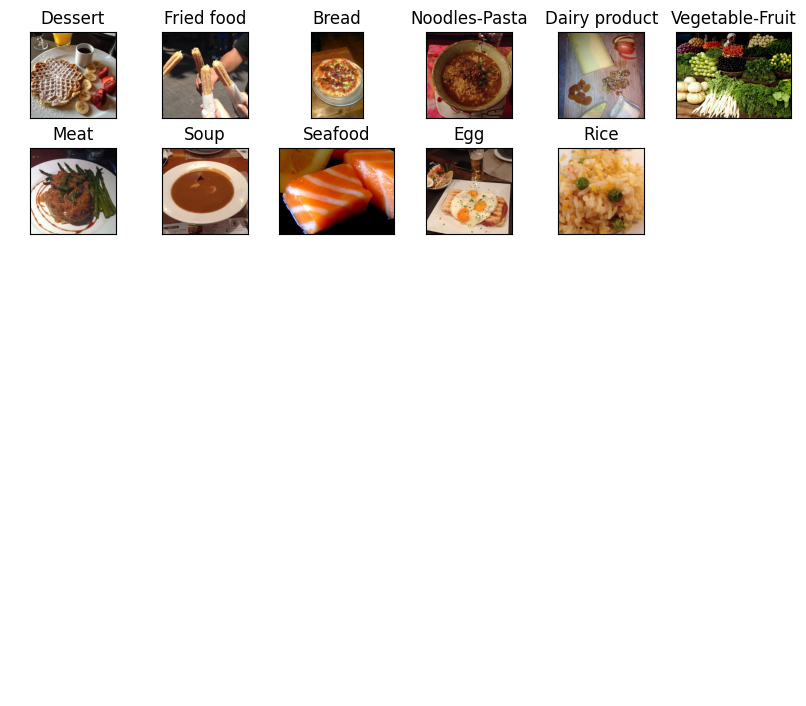

In [63]:
# Create a dataframe with one label of each category
df_unique = train_df.drop_duplicates(subset=["Label"]).reset_index(drop=True)

# Determine the number of unique labels
num_unique_labels = len(df_unique)

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < num_unique_labels:
        ax.imshow(plt.imread(df_unique.Filepath[i]))
        ax.set_title(df_unique.Label[i], fontsize=12)
    else:
        ax.axis('off')  # Hide any unused subplots

plt.tight_layout(pad=0.5)
plt.show()


In [64]:
# Prepare the data generators
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [65]:
train_images = train_gen.flow_from_dataframe(
   dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    roatation_range=30,
    zoom_range=15,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    subset='training'
)
val_images = train_gen.flow_from_dataframe(
   dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    roatation_range=30,
    zoom_range=15,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    subset='training'
)
test_images = test_gen.flow_from_dataframe(
   dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    roatation_range=30,
    zoom_range=15,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    subset='training'
)


Found 3347 validated image filenames belonging to 11 classes.
Found 3347 validated image filenames belonging to 11 classes.
Found 3347 validated image filenames belonging to 11 classes.


In [66]:
pretrained_model=tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable=False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [69]:
inputs=pretrained_model.input 
x=tf.keras.layers.Dense(512, activation='relu')(pretrained_model.output)
x=tf.keras.layers.Dense(512, activation='relu')(x)

outputs=tf.keras.layers.Dense(11, activation='softmax')(x)
model=tf.keras.Model(inputs=inputs,outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [70]:

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size=32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=2, restore_best_weights=True)
    ]
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


105/105 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.5916 - loss: 1.2301 - val_accuracy: 0.8593 - val_loss: 0.4153
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8880 - loss: 0.3660 - val_accuracy: 0.9501 - val_loss: 0.1790
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9354 - loss: 0.1912 - val_accuracy: 0.9202 - val_loss: 0.2191
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9647 - loss: 0.1164 - val_accuracy: 0.9869 - val_loss: 0.0558
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9782 - loss: 0.0652 - val_accuracy: 0.9982 - val_loss: 0.0124
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9929 - loss: 0.0306 - val_accuracy: 0.9889 - val_loss: 0.0343
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9950 - loss: 0.0252 - val_accuracy: 0.9979 - val_loss: 0.0137


In [71]:
# Predict the labels
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)
# Map the labels
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred1 = [labels[k] for k in pred]

print(pred1)

105/105 ━━━━━━━━━━━━━━━━━━━━ 76s 710ms/step
['Fried food', 'Egg', 'Dessert', 'Seafood', 'Dairy product', 'Vegetable-Fruit', 'Fried food', 'Fried food', 'Meat', 'Seafood', 'Fried food', 'Soup', 'Fried food', 'Fried food', 'Bread', 'Fried food', 'Seafood', 'Dessert', 'Bread', 'Egg', 'Soup', 'Bread', 'Dessert', 'Soup', 'Vegetable-Fruit', 'Soup', 'Dessert', 'Soup', 'Bread', 'Dessert', 'Seafood', 'Dairy product', 'Soup', 'Soup', 'Vegetable-Fruit', 'Soup', 'Noodles-Pasta', 'Dairy product', 'Meat', 'Vegetable-Fruit', 'Rice', 'Bread', 'Bread', 'Egg', 'Egg', 'Noodles-Pasta', 'Meat', 'Meat', 'Seafood', 'Dessert', 'Dessert', 'Seafood', 'Meat', 'Vegetable-Fruit', 'Egg', 'Dessert', 'Soup', 'Dairy product', 'Egg', 'Fried food', 'Seafood', 'Seafood', 'Dessert', 'Rice', 'Dessert', 'Dessert', 'Meat', 'Egg', 'Egg', 'Noodles-Pasta', 'Meat', 'Meat', 'Dessert', 'Dessert', 'Soup', 'Noodles-Pasta', 'Meat', 'Dessert', 'Fried food', 'Meat', 'Egg', 'Dessert', 'Soup', 'Bread', 'Egg', 'Soup', 'Bread', 'Soup', 'Ve

In [72]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class=answer.argmax(axis=-1)
    y=" ".join(str(x) for x in y_class)
    y=int(y)
    res=labels[y]
    return res

In [80]:
#predict the fooditem from image
img = output('/kaggle/input/food11-image-dataset/evaluation/Bread/0.jpg')
food_item=img
food_item

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


'Bread'

In [76]:
model.save('FV.h5')

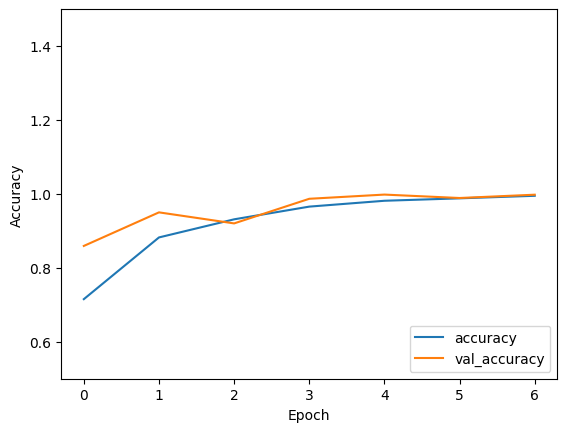

In [77]:

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5,1.5])
plt.legend(loc='lower right')
plt.show()

In [92]:
import requests
import json

# Function to fetch calorie information from Google
def get_calories_from_google(food_item):
    api_key = "YOUR_API_KEY"  # Replace 'YOUR_API_KEY' with your actual API key
    cx = "YOUR_CUSTOM_SEARCH_ENGINE_ID"  # Replace 'YOUR_CUSTOM_SEARCH_ENGINE_ID' with your actual Custom Search Engine ID
    query = f"{food_item} calories"
    url = f"https://www.googleapis.com/customsearch/v1?key={api_key}&cx={cx}&q={query}"

    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Error: Received response code {response.status_code}")
        return "unknown"
    
    data = response.json()
    
    try:
        items = data.get("items", [])
        if items:
            snippet = items[0].get("snippet", "")
            calories = snippet.split(" ")[0]  # Extracting calories from the snippet
            return calories
    except AttributeError:
        print(f"Could not find calorie information for {food_item} using Google.")
        return "unknown"
    
    return "unknown"

# Example usage
predicted_food_items = ['cabbage']  # Assuming you have predicted food items

for food_item in predicted_food_items:
    calories = get_calories_from_google(food_item)
    print(f"The estimated calories for {food_item} are {calories if calories != 'unknown' else 'unknown'} kcal.")


Error: Received response code 400
The estimated calories for cabbage are unknown kcal.


In [95]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Functions for fetching calorie information
def get_calories_from_calories_info(food_item):
    url = "https://www.calories.info/food/fruit"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        print(f"Error: Received response code {response.status_code}")
        return "unknown"
    
    soup = BeautifulSoup(response.text, 'html.parser')
    
    try:
        calorie_info = soup.find_all("tr")
        for row in calorie_info:
            columns = row.find_all("td")
            if len(columns) > 1 and food_item.lower() in columns[0].text.lower():
                calories = columns[1].text.strip().split(' ')[0]
                return calories
    except AttributeError:
        print(f"Could not find calorie information for {food_item} on calories.info.")
        return "unknown"
    
    return "unknown"

def get_calories_from_myfitnesspal(food_item):
    url = f"https://www.myfitnesspal.com/food/search?page=1&search={food_item}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        print(f"Error: Received response code {response.status_code}")
        return "unknown"
    
    soup = BeautifulSoup(response.text, 'html.parser')
    
    try:
        calorie_info = soup.find_all("div", class_="jss115")
        for item in calorie_info:
            name = item.find("h2").text
            if food_item.lower() in name.lower():
                calories = item.find("p", class_="jss138").text.split(' ')[0]
                return calories
    except AttributeError:
        print(f"Could not find calorie information for {food_item} on myfitnesspal.com.")
        return "unknown"
    
    return "unknown"

def get_calories(food_item):
    calories = get_calories_from_calories_info(food_item)
    if calories == "unknown":
        calories = get_calories_from_myfitnesspal(food_item)
    return calories

# Functions for predicting food items
def preprocess_images(image_paths):
    processed_images = []
    for path in image_paths:
        img = load_img(path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)  # MobileNetV2 specific preprocessing
        processed_images.append(img_array)
    return np.vstack(processed_images)

def predict_food_item(model, image_paths, class_indices):
    test_images = preprocess_images(image_paths)
    predictions = model.predict(test_images)
    pred_classes = np.argmax(predictions, axis=1)
    
    label_map = dict((v, k) for k, v in class_indices.items())
    predicted_labels = [label_map[k] for k in pred_classes]
    
    return predicted_labels

# Example usage
image_paths = ['/kaggle/input/food11-image-dataset/training/Bread/0.jpg']

# Using the already defined and trained model and class_indices
predicted_food_items = predict_food_item(model, image_paths, train_images.class_indices)

for food_item in predicted_food_items:
    calories = get_calories(food_item)
    print(f"The estimated calories for {food_item} are {calories if calories != 'unknown' else 'unknown'} kcal.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
The estimated calories for Bread are 100 kcal.
